<a href="https://colab.research.google.com/github/luigiselmi/timeseries/blob/main/traffic_forecast_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metro Interstate Traffic Volume Forecasting (Part 2)
This notebook is based on chapter 13 of the book [*Time Series Forecasting in Python*](https://www.manning.com/books/time-series-forecasting-in-python-book) by Marco Peixeiro. Classical algorithms for time series forecasting, are

* $Moving Average MA(q)$
* $Auto Regressive AR(p)$
* $Autoregressive Moving Average ARMA(p,q)$
* $Autoregressive Integrated Moving Average ARIMA(p,d,q)$
* $SARIMA(p,d,q)(P,D,Q)_m$
* $SARIMAX$

where q is the order, or lag, of the time series, that is the number of previous elements in the series that are used for the forecast, p is the autocorrelation order, that is number of elements that are correlated, P and Q are the seasonal lag and autocorrelation order. These models try to fit a set of basis functions to the data depending on the chosen order $(p,d,q)(P,D,Q)_m$. With the neural networks we fit an unknown nonlinear function to the data.


In [1]:
!pip install -q tensorflow==2.16.1

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
print('NumPy version: %s'%np.__version__)
print('Pandas version: %s'%pd.__version__)
print('Matplotlib version: %s'%mpl.__version__)
print('TensorFlow version: %s'%tf.__version__)

NumPy version: 1.23.5
Pandas version: 2.2.2
Matplotlib version: 3.10.0
TensorFlow version: 2.16.1


## Data windowing
In order to train a model we split the data into time windows of the same length, for instance 24 hours. If the task is multistep forecasting, we use e.g. 24 hours as input data and the next 24 hours as target values so that a data window contains 48 hours. For example, the 1st window uses 48 hours starting from the 1st hour, the 2nd window uses 48 hours starting from the 2nd hour and so on. So there is an overlap of 47 hours between two consecutive data windows. We can create batches using a certain number of data windows, e.g. 32 data windows. The order for each data window cannot be changed but the order of the data windows in a batch can be shuffled.

In [4]:
train_df = pd.read_csv('data/metro_interstate_traffic/train.csv', index_col=0)
val_df = pd.read_csv('data/metro_interstate_traffic/val.csv', index_col=0)
test_df = pd.read_csv('data/metro_interstate_traffic/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [5]:
train_df.columns

Index(['temp', 'clouds_all', 'traffic_volume', 'day_sin', 'day_cos'], dtype='object')

The input features are: cloud_all, day_sin, and day_cos. The label features are: temp, and traffic_volume

In [6]:
day_enum = ['Friday',
            'Saturday',
            'Sunday',
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday',
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday']

len(day_enum)

17

We can see the 48 hours data windows within the first 400 hours in our dataset, with square markers and blu color used for the 24 inputs of each data window, and cross markers and red color used for the labels.

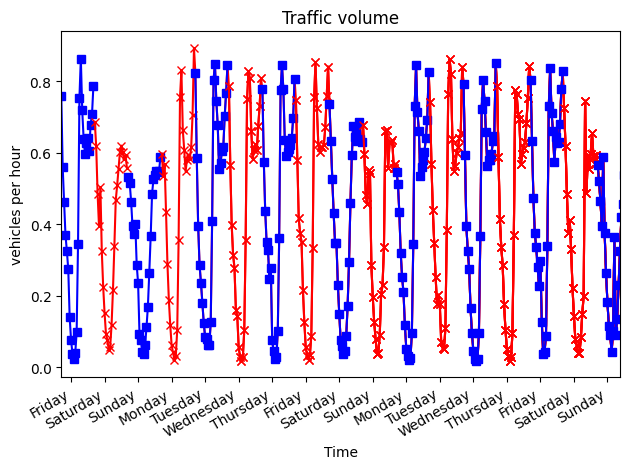

In [7]:
fig, ax = plt.subplots()
fig.autofmt_xdate()

for n in range(0, 17, 2):
    start = 24 * n
    stop = 24 * (n + 1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='blue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='red', label='label')

ax.set_title('Traffic volume')
ax.set_xlabel('Time')
ax.set_ylabel('vehicles per hour')
plt.xticks(np.arange(start=7, stop=400, step=24), day_enum)
plt.xlim(0, 400)
plt.tight_layout()

## Deep learning model
Deep learning model might perform better than classical time series models when the dataset available is large and contains signals that are complex. For example SARIMAX can be used only when there is only one kind of seasonality or cycle. In general deep learning model can be used when there is some nonlinear relationship between the input, in our example the meteorological variables and holidays and the target. The DataWindow class has four arguments to be passed to create an instance: the inputs width, in our example 24, the labels width, also 24 in our example, the shift that is also 24 in case of multistep prediction, and the name of the label column in the training, validation, and test sets. The DataWindow class creates batches of windows of inputs and labels by sliding through the dataset. The size of each batch is set to 32 so the number of batches depends on the number of observations in the train, validation, and test datasets

In [8]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        '''
        This function separates inputs and labels from the features.
        '''
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        '''
        The function plots the model's predictions for three data windows
        '''
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        '''
        This function is based on a Keras function to create batches of data sliding windows of inputs and lables from the train, validation, and test sets.
        The slide is set with the sequence_stride argument. The data windows are shuffled but the order within each window is preserved.
        '''
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

## Single-step model
To begin with, we use the DataWindow class to train a single-step model to predict the value of a target variable, e.g. the traffic volume, only one step in the future using an input with only one value. In this case the length of each window in the training set is 2, one for the input and one for the label.  

In [16]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])

We create also a window of size 24 for plotting purposes

In [21]:
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

We create a custom baseline model by subclassing the [Keras Model](https://keras.io/api/models/model/) class. With only one input value the best prediction we can make is simply to return the same input value. So there's no need to train the model.

In [10]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [11]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
column_indices

{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}

In [12]:
baseline_last = Baseline(label_index=column_indices['traffic_volume'])

We configure the loss function as the mean squared error ([MSE](https://en.wikipedia.org/wiki/Mean_squared_error)), and the metric as the mean absolute error ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)) using the compile method of the Keras Model class

In [19]:
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [20]:
baseline_last.summary()


Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

We assess the performance of the baseline model against the validation and the test set

In [14]:
val_performance = {}
performance = {}
val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0820


We call the plot method of the wide window passing the baseline model that contains the computes predictions. By default the method plots the predictions for three data windows.  

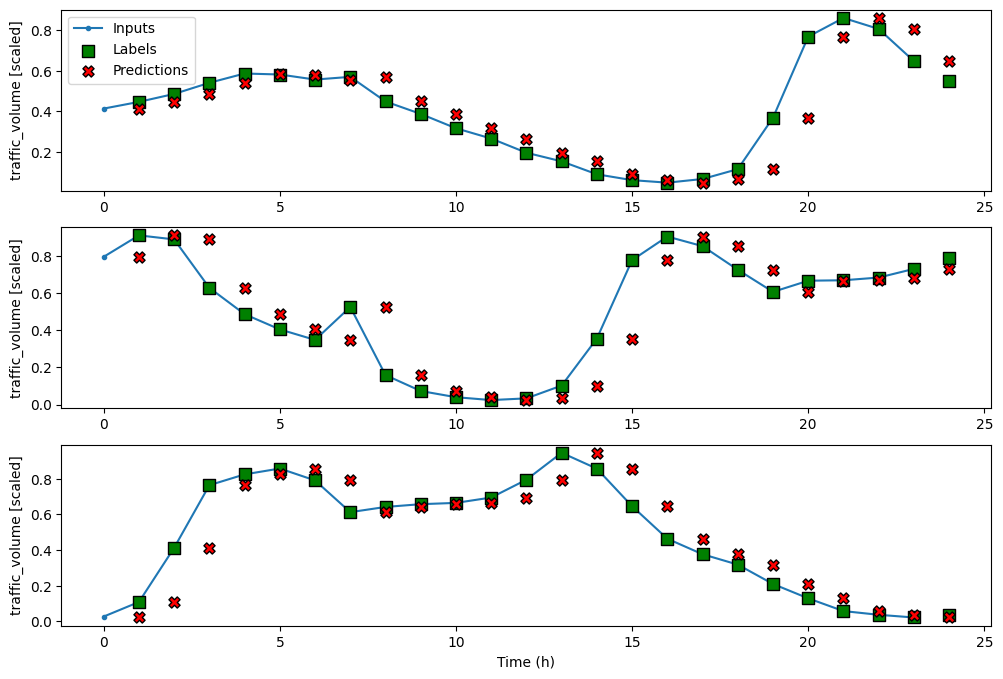

In [15]:
wide_window.plot(baseline_last)

In [23]:
print('MAE on the test set: {:.2f}'.format(performance['Baseline - Last'][1]))

MAE on the test set: 0.08
